In [2]:
#!/usr/bin/env python3

import pandas as pd
import errno    
import os, sys
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams['figure.figsize'] = (20,5)

'''
Author: Enrico Ceccolini
'''

datadir = "/datasets/eurora_data/db1/"

# settings
interval_comment = "Andrea"
start_time = pd.to_datetime('2014-03-31')
end_time = pd.to_datetime('2014-05-01')
#interval_comment = "Alina"
#start_time = pd.to_datetime('2014-09-30')
#end_time = pd.to_datetime('2014-11-01')
suffix = "_1min_"  

infile_jobs = datadir + "CPUs/" + interval_comment + "/large_jobs_real_pow_" + interval_comment + ".csv"
interval_jobs = pd.read_csv(infile_jobs, index_col=0)
print("There are {} jobs in the {}'s interval".format(interval_jobs.shape[0], interval_comment))

There are 22459 jobs in the Andrea's interval


Calculate the number of jobs that ran alone during all their life

In [4]:
num_ran_alone = interval_jobs[interval_jobs['ran_alone'] == True].shape[0]
print("{} jobs ran alone".format(num_ran_alone))

13155 jobs ran alone


In [5]:
### expensive jobs
expensive_jobs = interval_jobs[interval_jobs['real_pow'] > 2000]
#print("{} jobs ran alone".format(num_ran_alone))
#expensive_jobs

Calculate the number of distinct users that used the service in this period

In [6]:
grouped_user_data = interval_jobs.groupby('user')['job_id_string'].nunique().reset_index(name='counts')
print("{} distinct users".format(grouped_user_data.shape[0]))
# grouped_user_data.sort_values('counts', ascending=False)

226 distinct users


Calculate the number of users that ran a great number of jobs in this period

In [7]:
print("{} users ran more than 100 jobs in the interval".format(grouped_user_data[grouped_user_data['counts'] >= 100].shape[0]))

37 users ran more than 100 jobs in the interval


Calculate the number of distinct jobs names

In [8]:
grouped_jobs_data = interval_jobs.groupby('job_name')['job_id_string'].nunique().reset_index(name='counts')
print("{} distinct jobs names".format(grouped_jobs_data.shape[0]))

2639 distinct jobs names


Users that ran more than 100 times jobs with the same name

In [11]:
grouped_jobs_data = interval_jobs.groupby(['user', 'job_name'])['job_id_string'].nunique().reset_index(name='counts')
grouped_jobs_data = grouped_jobs_data.sort_values('counts', ascending=False)
print("{} users ran more than 100 time a job with the same name".format(grouped_jobs_data[grouped_jobs_data['counts'] >= 100].shape[0]))

24 users ran more than 100 time a job with the same name


In [12]:
grouped_jobs_data.head(5)

,user,job_name,counts
1351,fpetracc@node129.eurora.cineca.it,cosmomc_nMin20_,1576
1554,jfranz00@node129.eurora.cineca.it,g.job,511
3039,tbusatta@node129.eurora.cineca.it,scriptcineca_10,377
3043,tbusatta@node129.eurora.cineca.it,scriptcineca_50,313
3042,tbusatta@node129.eurora.cineca.it,scriptcineca_40,309


Andrea said that job_names are useless because they are confusionary. Users ran completely distinct jobs with the same name

In [70]:
#job_instance

## Looking jobs by user

User 1

In [131]:
user_id = "asaetti0@node129.eurora.cineca.it"

specific_user_jobs = interval_jobs[interval_jobs['user'] == user_id]
resources_grouped = specific_user_jobs.groupby(['queue', 'node_req', 'cpu_req', 'mem_req'])['job_id_string'].nunique().reset_index(name='counts')
resources_grouped

,queue,node_req,cpu_req,mem_req,counts
0,debug,0,0,0,2883
1,debug,0,1,4,1
2,debug,1,1,4,3288


In [132]:
print("there are {} entries".format(specific_user_jobs.shape[0]))
print("the std of the real pow is {}".format(specific_user_jobs['real_pow'].std()))

specific_user_jobs = specific_user_jobs.loc[(specific_user_jobs['real_pow_quality'] == 1.0) & (specific_user_jobs['ran_alone'] == True)]
print("there are {} entries".format(specific_user_jobs.shape[0]))
print("the std of the real pow is {}".format(specific_user_jobs['real_pow'].std()))

print("the mean value is {}".format(specific_user_jobs['real_pow'].mean()))

there are 6172 entries
the std of the real pow is 35.05937227065127
there are 3055 entries
the std of the real pow is 35.8379885433063
the mean value is 42.32632065131466


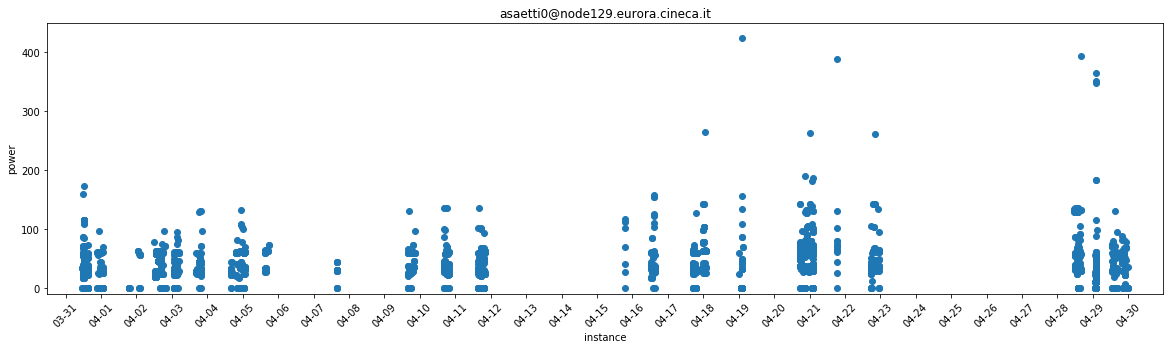

In [133]:
dates = []

for ts in specific_user_jobs['run_start_time']:
    local_d = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
    dates.append(local_d)
    
fig, ax = plt.subplots()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.scatter(dates, specific_user_jobs['real_pow'])
# plt.axis([dates[0], dates[len(dates)-1], -5, 80])
plt.axis([dates[0] - pd.offsets.Day(1), dates[len(dates)-1] + pd.offsets.Day(1), -10, 450])
plt.xlabel("instance")
plt.ylabel("power")
plt.title(user_id)
plt.show()

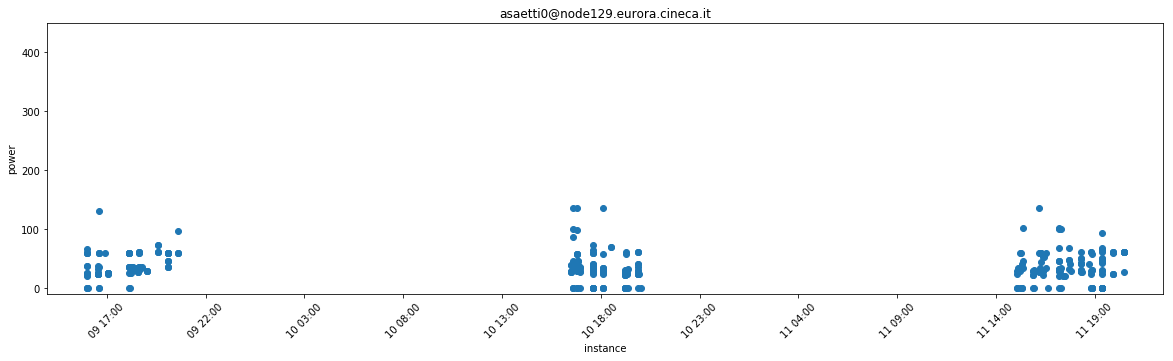

In [134]:
# ZOOM 3 days
dates = []
day = specific_user_jobs[pd.to_datetime(specific_user_jobs['run_start_time']) < pd.to_datetime('2014-04-13')]
day = day[pd.to_datetime(day['run_start_time']) > pd.to_datetime('2014-04-09')]
for ts in day['run_start_time']:
    local_d = pd.to_datetime(ts)
    dates.append(local_d)
    
fig, ax = plt.subplots()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))

plt.scatter(dates, day['real_pow'])
plt.axis([dates[0] - pd.offsets.Hour(2), dates[len(dates)-1] + pd.offsets.Hour(2), -10, 450])
plt.xlabel("instance")
plt.ylabel("power")
plt.title(user_id)
plt.show()

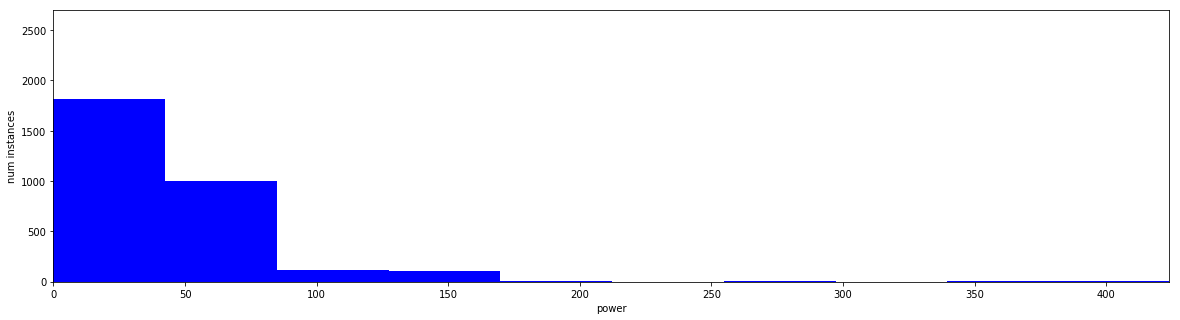

In [135]:
num_bins = 10
n, bins, patches = plt.hist(specific_user_jobs['real_pow'], num_bins, facecolor='blue', alpha=1)
plt.axis([int(specific_user_jobs['real_pow'].min()), int(specific_user_jobs['real_pow'].max()), 0, 2700])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()

User 2

In [6]:
user_id = "a07smr01@node129.eurora.cineca.it"

specific_user_jobs = interval_jobs[interval_jobs['user'] == user_id]
resources_grouped = specific_user_jobs.groupby(['queue', 'node_req', 'cpu_req', 'mem_req'])['job_id_string'].nunique().reset_index(name='counts')
resources_grouped.sort_values('node_req', ascending=False).head(10)

,queue,node_req,cpu_req,mem_req,counts
60,meteopar,11,176,154,2
1,R472836,11,176,154,1
15,R544947,11,176,154,4
13,R509757,11,176,154,5
10,R505112,11,176,154,8
18,R563598,11,176,154,1
32,R565862,11,176,154,3
3,R498534,11,176,154,1
31,R565862,10,160,140,1
12,R509757,10,160,140,1


In [136]:
user_id = "a07smr01@node129.eurora.cineca.it"

specific_user_jobs = interval_jobs[interval_jobs['user'] == user_id]
resources_grouped = specific_user_jobs.groupby(['job_name', 'node_req', 'cpu_req', 'mem_req'])['job_id_string'].nunique().reset_index(name='counts')
resources_grouped

,job_name,node_req,cpu_req,mem_req,counts
0,ARKI,0,0,0,4
1,INIT,0,0,0,26
2,INIT,1,1,2,32
3,LM28_OPE,0,0,0,17
4,LM7_OPE,0,0,0,1
5,LM_PRE,0,0,0,37
6,LM_PRE,10,160,140,2
7,LM_PRE,11,176,154,25


In [137]:
print("there are {} entries".format(specific_user_jobs.shape[0]))
print("the std of the real pow is {}".format(specific_user_jobs['real_pow'].std()))


specific_job = specific_user_jobs.loc[(specific_user_jobs['job_name'] == 'LM_PRE') & (specific_user_jobs['node_req'] == 11)]
specific_job = specific_job.loc[(specific_job['real_pow_quality'] >= 0.5)]

print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

print("the mean value is {}".format(specific_job['real_pow'].mean()))

there are 144 entries
the std of the real pow is 1433.9289605073668
there are 22 entries
the std of the real pow is 1077.0035532614181
the mean value is 2062.315265268306


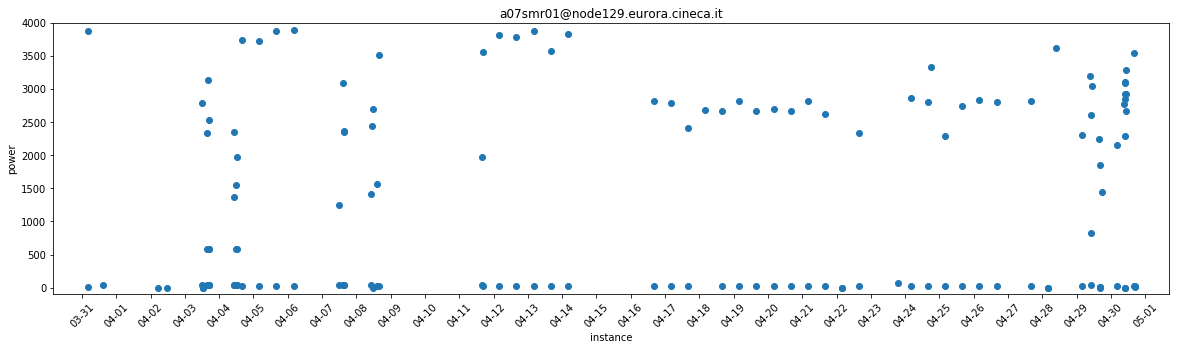

In [139]:
dates = []
for ts in specific_user_jobs['run_start_time']:
    local_d = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
    dates.append(local_d)
    
fig, ax = plt.subplots()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.scatter(dates, specific_user_jobs['real_pow'])
plt.axis([dates[0] - pd.offsets.Day(1), dates[len(dates)-1] + pd.offsets.Day(1), -100, 4000])
plt.xlabel("instance")
plt.ylabel("power")
plt.title(user_id)
plt.show()

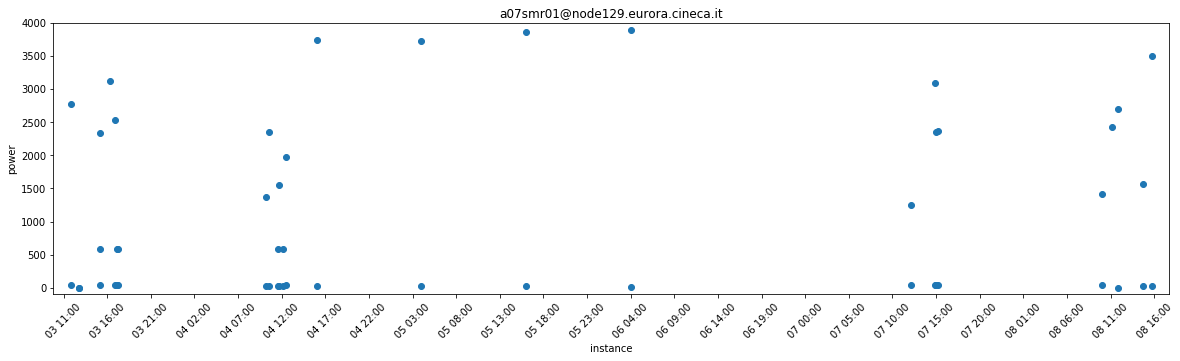

In [140]:
#ZOOM 5 days
dates = []
day = specific_user_jobs[pd.to_datetime(specific_user_jobs['run_start_time']) < pd.to_datetime('2014-04-09')]
day = day[pd.to_datetime(day['run_start_time']) > pd.to_datetime('2014-04-03')]
for ts in day['run_start_time']:
    local_d = pd.to_datetime(ts)
    dates.append(local_d)
    
fig, ax = plt.subplots()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))

plt.scatter(dates, day['real_pow'])
plt.axis([dates[0] - pd.offsets.Hour(2), dates[len(dates)-1] + pd.offsets.Hour(2), -100, 4000])
plt.xlabel("instance")
plt.ylabel("power")
plt.title(user_id)
plt.show()

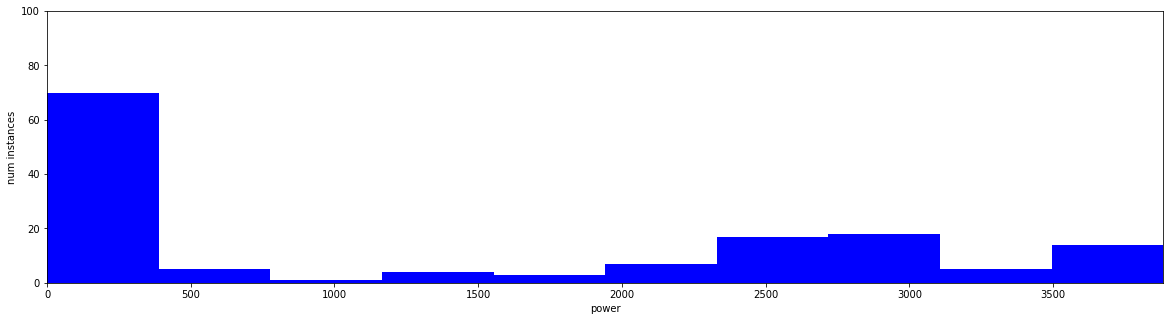

In [130]:
num_bins = 10
n, bins, patches = plt.hist(specific_user_jobs['real_pow'], num_bins, facecolor='blue', alpha=1)
plt.axis([int(specific_user_jobs['real_pow'].min()), int(specific_user_jobs['real_pow'].max()), 0, 100])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()

### Looking jobs by name
Job 1

In [157]:
job_id = "scriptcineca_40"

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
resources_grouped = specific_job.groupby(['queue', 'node_req', 'cpu_req', 'mem_req', 'time_req'])['job_id_string'].nunique().reset_index(name='counts')
resources_grouped

,queue,node_req,cpu_req,mem_req,time_req,counts
0,parallel,0,0,0,03:30,69
1,parallel,1,1,8,03:30,27


In [158]:
# job_instance = specific_job.iloc[0]
# queue, nodes, cpus, mem = job_instance['queue'], job_instance['node_req'], job_instance['cpu_req'], job_instance['mem_req']
# print("{} runs on queue {}".format(job_id, job_instance['queue']))

print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
specific_job = specific_job.loc[(specific_job['real_pow_quality'] == 1.0) & (specific_job['ran_alone'] == True)]
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

print("the mean value is {}".format(specific_job['real_pow'].mean()))

there are 309 entries
the std of the real pow is 35.5618271621107
there are 193 entries
the std of the real pow is 32.35648855453729
the mean value is 66.5045773730104


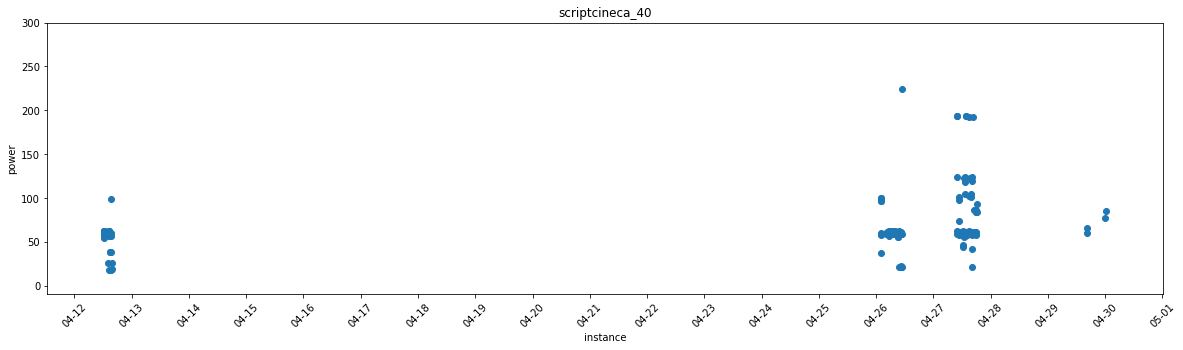

In [159]:
dates = []
for ts in specific_job['run_start_time']:
    local_d = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
    dates.append(local_d)
    
fig, ax = plt.subplots()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.scatter(dates, specific_job['real_pow'])
plt.axis([dates[0] - pd.offsets.Day(1), dates[len(dates)-1] + pd.offsets.Day(1), -10, 300])
plt.xlabel("instance")
plt.ylabel("power")
plt.title(job_id)
plt.show()

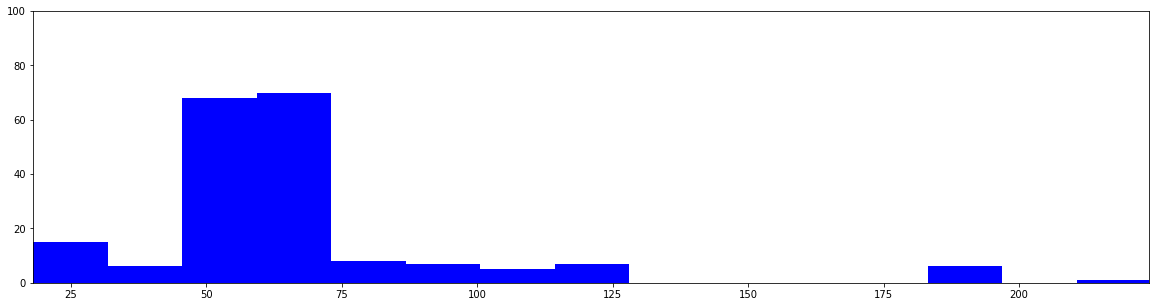

In [160]:
num_bins = 15
n, bins, patches = plt.hist(specific_job['real_pow'], num_bins, facecolor='blue', alpha=1)
plt.axis([int(specific_job['real_pow'].min()), int(specific_job['real_pow'].max()), 0, 100])
plt.show()

Job 2

In [161]:
job_id = "cosmomc_nMin20_"
specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
resources_grouped = specific_job.groupby(['queue', 'node_req', 'cpu_req', 'mem_req', 'time_req'])['job_id_string'].nunique().reset_index(name='counts')

resources_grouped

,queue,node_req,cpu_req,mem_req,time_req,counts
0,parallel,0,0,0,04:00,123
1,parallel,1,8,200,04:00,1087


In [162]:
specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
specific_job = specific_job[specific_job['real_pow_quality'] == 1.0]
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

print("the mean value is {}".format(specific_job['real_pow'].mean()))

there are 1576 entries
the std of the real pow is 97.42601825543801
there are 1435 entries
the std of the real pow is 93.78438103982047
the mean value is 158.6926283440624


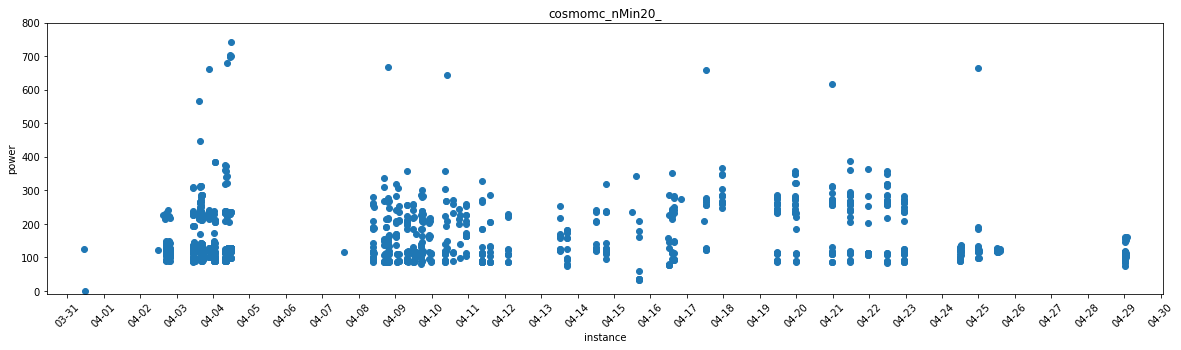

In [164]:
dates = []
for ts in specific_job['run_start_time']:
    local_d = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
    dates.append(local_d)
    
fig, ax = plt.subplots()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.scatter(dates, specific_job['real_pow'])
plt.axis([dates[0] - pd.offsets.Day(1), dates[len(dates)-1] + pd.offsets.Day(1), -10, 800])
plt.xlabel("instance")
plt.ylabel("power")
plt.title(job_id)
plt.show()

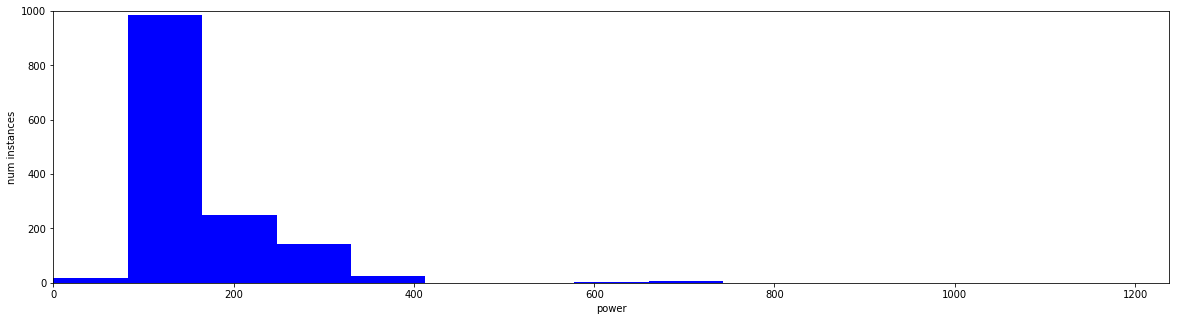

In [163]:
num_bins = 15
n, bins, patches = plt.hist(specific_job['real_pow'], num_bins, facecolor='blue', alpha=1)
plt.axis([int(specific_job['real_pow'].min()), int(specific_job['real_pow'].max()), 0, 1000])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()

Job 3

In [167]:
job_id = "g.job"

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
resources_grouped = specific_job.groupby(['queue', 'node_req', 'cpu_req', 'mem_req', 'time_req'])['job_id_string'].nunique().reset_index(name='counts')
resources_grouped

,queue,node_req,cpu_req,mem_req,time_req,counts
0,debug,0,0,0,00:29,194
1,debug,1,4,4,00:29,137
2,parallel,0,0,0,01:29,163
3,parallel,0,0,0,03:30,15
4,parallel,1,4,4,03:30,2


In [168]:
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
specific_job = specific_job.loc[(specific_job['real_pow_quality'] == 1.0) & (specific_job['ran_alone'] == True)]
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

print("the mean value is {}".format(specific_job['real_pow'].mean()))

there are 511 entries
the std of the real pow is 35.73889247847243
there are 392 entries
the std of the real pow is 35.32378405267902
the mean value is 102.32586813706087


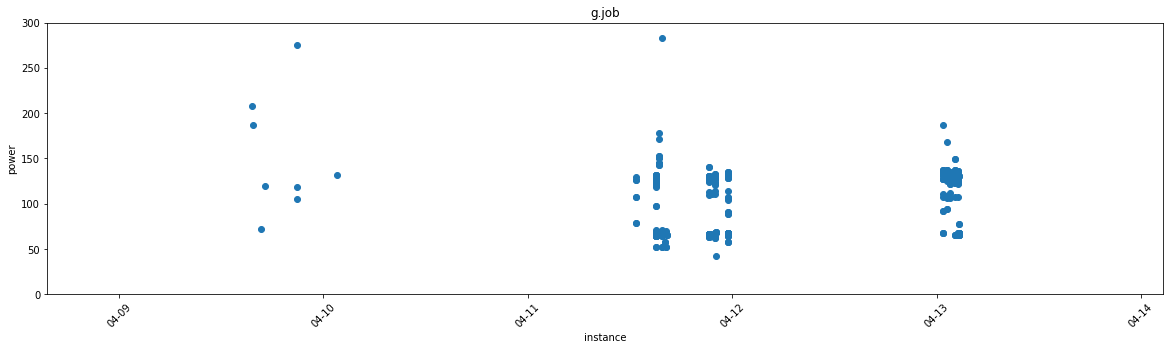

In [173]:
dates = []
for ts in specific_job['run_start_time']:
    local_d = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
    dates.append(local_d)
    
fig, ax = plt.subplots()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.scatter(dates, specific_job['real_pow'])
plt.axis([dates[0] - pd.offsets.Day(1), dates[len(dates)-1] + pd.offsets.Day(1), 0, 300])
plt.xlabel("instance")
plt.ylabel("power")
plt.title(job_id)
plt.show()

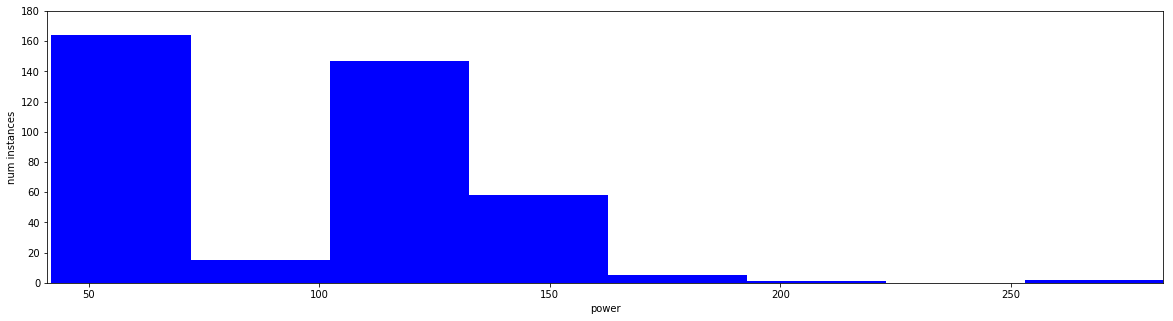

In [169]:
num_bins = 8
n, bins, patches = plt.hist(specific_job['real_pow'], num_bins, facecolor='blue', alpha=1)
plt.axis([int(specific_job['real_pow'].min()), int(specific_job['real_pow'].max()), 0, 180])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()

Job 4

In [174]:
job_id = "scriptcineca_10"

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
resources_grouped = specific_job.groupby(['queue', 'node_req', 'cpu_req', 'mem_req', 'time_req'])['job_id_string'].nunique().reset_index(name='counts')
resources_grouped

,queue,node_req,cpu_req,mem_req,time_req,counts
0,parallel,0,0,0,03:30,36
1,parallel,0,1,8,03:30,1
2,parallel,1,1,8,03:30,50


In [175]:
specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
specific_job = specific_job.loc[(specific_job['real_pow_quality'] == 1.0) & (specific_job['ran_alone'] == True)]
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

print("the mean value is {}".format(specific_job['real_pow'].mean()))

there are 377 entries
the std of the real pow is 41.95927545750325
there are 126 entries
the std of the real pow is 47.10318573005564
the mean value is 67.32232790608158


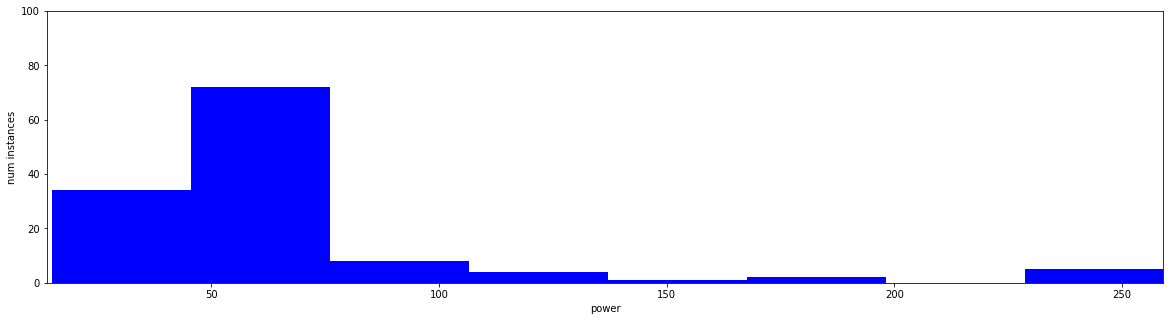

In [176]:
num_bins = 8
n, bins, patches = plt.hist(specific_job['real_pow'], num_bins, facecolor='blue', alpha=1)
plt.axis([int(specific_job['real_pow'].min()), int(specific_job['real_pow'].max()), 0, 100])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()

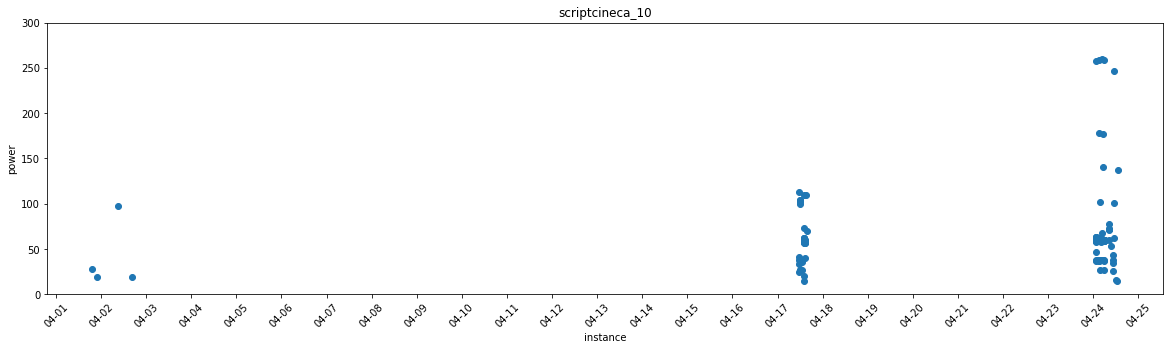

In [177]:
dates = []
for ts in specific_job['run_start_time']:
    local_d = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
    dates.append(local_d)
    
fig, ax = plt.subplots()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.scatter(dates, specific_job['real_pow'])
plt.axis([dates[0] - pd.offsets.Day(1), dates[len(dates)-1] + pd.offsets.Day(1), 0, 300])
plt.xlabel("instance")
plt.ylabel("power")
plt.title(job_id)
plt.show()

Job 5

In [178]:
job_id = "scriptcineca_50"

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
resources_grouped = specific_job.groupby(['queue', 'node_req', 'cpu_req', 'mem_req', 'time_req'])['job_id_string'].nunique().reset_index(name='counts')
resources_grouped

,queue,node_req,cpu_req,mem_req,time_req,counts
0,parallel,0,0,0,03:30,141
1,parallel,1,1,8,03:30,51


In [179]:
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
specific_job = specific_job.loc[(specific_job['real_pow_quality'] == 1.0) & (specific_job['ran_alone'] == True)]
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

print("the mean value is {}".format(specific_job['real_pow'].mean()))

there are 313 entries
the std of the real pow is 33.03988559748996
there are 171 entries
the std of the real pow is 34.98677787065265
the mean value is 56.237789799212045


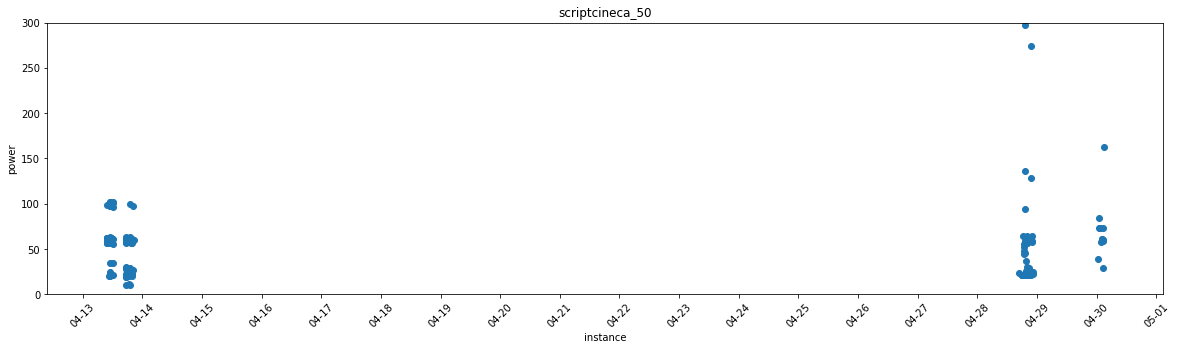

In [181]:
dates = []
for ts in specific_job['run_start_time']:
    local_d = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
    dates.append(local_d)
    
fig, ax = plt.subplots()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.scatter(dates, specific_job['real_pow'])
plt.axis([dates[0] - pd.offsets.Day(1), dates[len(dates)-1] + pd.offsets.Day(1), 0, 300])
plt.xlabel("instance")
plt.ylabel("power")
plt.title(job_id)
plt.show()

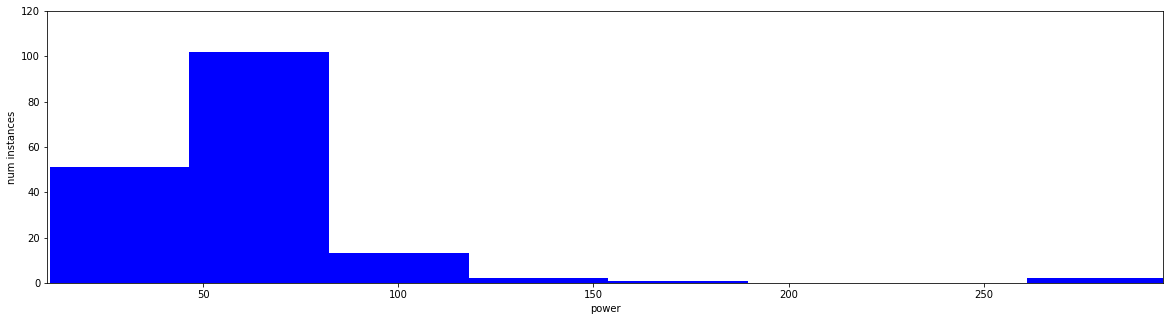

In [180]:
num_bins = 8
n, bins, patches = plt.hist(specific_job['real_pow'], num_bins, facecolor='blue', alpha=1)
plt.axis([int(specific_job['real_pow'].min()), int(specific_job['real_pow'].max()), 0, 120])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()

In [51]:
# resources [1]
# The default memory assigned to a job, if not explicitly requested, is 1GB per node

def get_wall_values(queue):
    if(queue == "debug"):
        nodes, cpus, mem = 2, 32, 1
    elif(queue == "parallel"):
        nodes, cpus, mem = 32, 512, 1
    elif(queue == "longpar"):
        nodes, cpus, mem = 16, 256, 1
    return nodes, cpus, mem

In [82]:
#specific_job.sort_values('real_pow', ascending=False)

[1] http://www.training.prace-ri.eu/training_material/uploads/tx_pracetmo/EURORAEnv.pdf